# Scientific Publishing Senior Data Analyst Take Home Task - Associative Rules Mining

## Tables of Contents

 - Brief and Preparation
     - Context
     - The Brief
         - The Data Provided
     - My Approach
         - Preparation
 - Preparing and Encoding the Data
     - Load and Display data
     - Transform the data
         - Transforming continuous data into discrete data
             - Using qcut to cut the continuous data 
         - One-hot encoding the data
         - Filtering the data before carrying out associative rule mining
 - Association Rule Mining
     - Setting Association Rules Mining Parameters and Executing¶
         - Setting Parameters
         - Executing
 - Results
     - Recommendations
 - Outro

## Brief and Preparation

### Context

In March 2025 I carried out a case study as part of the interview process for a Senior Data Analyst role at a large scientific publishing organisation. It led to a job offer, but I chose to go forward with a different organisation more aligned to my career journey.

This notebook is a write up of my code on how I approached the business problem in the case study, using predictive analytics – specifically Market Baset Analysis, or Association Rule Mining.

You can learn more about the business problem, why I chose Association Rule Mining, and the result in my portfolio case study [here](https://theheasman.com/portfolio/predictive-analytics-science-publisher/). 

### The Brief

*For more information, or a more detailed brief, please see the portfolio write up [here](https://theheasman.com/portfolio/predictive-analytics-science-publisher/).*

ERS was bought by TRS, ERS revenue growth was particuarly high, at 28% year on year. 

The recent acquisition prompted a full review of the business, to identify any potential opportunities or risks to growth. 

During the review the Head of Sales identified something alarming:
</br>

<div class="flourish-embed flourish-chart" data-src="visualisation/17567952"><script src="https://public.flourish.studio/resources/embed.js"></script><noscript><img src="https://public.flourish.studio/visualisation/17567952/thumbnail" width="100%" alt="chart visualization" /></noscript></div>

Over $5.6 million of revenue had been lost through churned/lapsed accounts, but this had been hidden because new business was compensating so much for revenue. 

This poses a risk to future revenue. The Head of Sales has tasked the Data Analyst with the following question:

**How can we identify accounts at risk of cancelling their subscription?**

#### The Data Provided

Through contacts in the data team you have found five datasets to help answer the question. This covers 2015 and 2016 activity for a random sample of 10,000 ERS accounts. 

 - ACCOUNTS.csv - high level attributes for each account, including year customer subscribed
 - NPS.csv - Net Promoter Score (NPS) survey results for account holders
 - REVENUE.csv - what subscriptions accounts subscribe to, and for how much (there are three options)
 - USAGE.csv - number of unique usage sessions for each subscription type
 - USERS.csv - total number of unique users associated with each account per subscription year
 
 Also:
  - The data is clean, there are no data errors or innacuracies, but there are NA values
  - There are no duplicates

### My Approach

This business problem can be classified as a churn analysis problem - identify which factors are likely to lead to customers churning. This can also be used for employee churn, or to see which items in an e-commerce store are likely to sell together.

The solution required is a categorical piece of data, not a continuous series of data. 

As such, a **Market Basket Analysis** (also known as **Association Rule Mining**) was chosen to gain insights from the data. This would give me a rule for which factors are most closely associated to each other for a given output. 

Imagine two sides of a table, or two sides of an equation. There is the left hand side, the series of variables, or the inputs. Then there is the right hand side, the output.

The goal would be to define customers that have churned on the right hand side, and to find the series of association rules on the left hand side that lead to the most **lift**. 

Lift is how much more likely these group of variables will lead to the outcome than everything else. E.g. to use an employee churn example – employees with tenure over 3 years with two or more manager changes might have a lift of 1.8x to leave the company, compared to everyone else.

The higher the lift, the more likely these combined variables will lead to the outcome.

For a more visual representation and breakdown of this, please see my portfolio write up [here](https://theheasman.com/portfolio/predictive-analytics-science-publisher/).

This analysis can be carried out in Excel with the Solver module, however it will only provide you with the association rule with maximum lift. I wanted a list of the association rules and their corresponding lifts, in order. 

As such, I chose to carry this analysis out in Python 3.10 using the `mlxtend` library. 

#### Preparation

Before carrying out any analysis, I joined and transformed the csvs in Excel using Power Query. These were full outer joins on the Acct ID, a column all the datasets had. 

I next created a conditional column in Power Query using DAX to identify which customers had churned or not. This column called `Calc.IsLapsed` defines churned customers as having

 - \>=1 user in 2015 **AND** 0 users in 2016 
 
 **OR** 
 
 - Revenue >=1 in 2015 **AND** 0 revenue in 2016.

Missing, or NA data, was assumed to be 0, as these represented missing information (e.g. empty NPS surveys) or customers who were no longer accounts (NA usage for 2016). 

## Preparing and Encoding the Data

We will do association rule mining (or market basket analysis) with the apriori algorithm to find out the different variables that are likely to lead to churn. 

### Load and display data

First we'll load the data and display it

In [1]:
import pandas as pd

#Load CSV
df = pd.read_csv('merged_data.csv')

#Display first few rows
df.head()

,ACCT_ID,FIRST_YR_CUSTOMER,COUNTRY,ACCT_MGR_STATUS,ACCT_REVENUE_CAT,ACCT_EMPLOYEE_CAT,ACCT_TYPE,REVENUE.MEDICAL_REVENUE_2015,REVENUE.SCIENTIFIC_REVENUE_2015,REVENUE.TECHNICAL_REVENUE_2015,...,USAGE.MEDICAL_NO_SESSIONS_2016,USAGE.SCIENTIFIC_NO_SESSIONS_2016,USAGE.TECHNICAL_NO_SESSIONS_2016,USERS.USERS_2015,USERS.USERS_2016,NPS.NPS_SCORE_2015,NPS.NPS_SCORE_2016,Calc.TotalRevenue2015,Calc.TotalRevenue2016,Calc.IsLapsed
0,10000954,2016,GERMANY,HEAD OF FUNCTION,$1bn+,1001 - 5000 employees,Corporate,0.0,0.0,0.0,...,3.0,12.0,4.0,0,1,NaN,NaN,0.0,156.75,0
1,10256127,2013,UNITED STATES,HEAD OF FUNCTION,$500m-$1bn,501 - 1000 employees,Research,57.0,38.0,47.5,...,NaN,NaN,1.0,1,2,0.0,NaN,142.5,216.30,0
2,10526577,2014,GERMANY,SENIOR MANAGER,$1bn+,1001 - 5000 employees,Academic,57.0,38.0,47.5,...,11.0,9.0,NaN,1,1,NaN,NaN,142.5,149.63,0
3,12304211,2014,GERMANY,DIRECTOR OF FUNCTION,$20-$50m,11 - 50 employees,Research,300.0,0.0,250.0,...,47.0,NaN,78.0,5,6,0.0,NaN,550.0,516.60,0
4,10003769,2014,UNITED STATES,MANAGER,$50-$100m,100 - 500 employees,Academic,264.0,0.0,228.0,...,NaN,NaN,96.0,6,6,NaN,NaN,492.0,239.40,0


### Transform the data

The data needs to be transformed for association rule mining. This technique only works on data which is presented as columns with `1` or `0`. Or `True` or `False`. To encode your data into this format is called **one-hot encoding**. 

Our data is a mix of categorical and continuous data. 

For categorical data we can easily use Pandas `pandas.getdummies()` command to do this. But continuous data will need to be cut into discrete data, or the number of columns will be large, and the algorithm will take a long time to run (computation scales exponentially with the size of the dataset). 

#### Transforming continuous data into discrete data

These are the columns with continuous data that we need to transform.

 - Revenue.Medical_Revenue_2015
 - Revenue.Scientific_Revenue_2015
 - Revenue.Technical_Revenue_2015
 - Revenue.Medical_Revenue_2016
 - Revenue.Scientific_Revenue_2016
 - Revenue.Technical_Revenue_2016
 - Usage.Medical_No_Sessions_2015
 - Usage.Scientific_No_Sessions_2015
 - Usage.Technical_No_Sessions_2015
  - Usage.Medical_No_Sessions_2016
 - Usage.Scientific_No_Sessions_2016
 - Usage.Technical_No_Sessions_2016
- Users.Users_2015
- Users.Users_2016
- NPS.NPS_Score_2015
- NPS.NPS_Score_2016
- Calc.TotalRevenue2015
- Calc.TotalRevenue2016

We will discretely cut these into quartiles using `qcut`. Data that is NaN or 0 will be labeled as 'zero_label' so they are not lumped into the lowest quartile. Each bin will be called Q1, Q2, Q3, Q4, representing the lowest to the highest quartile.

So `REVENUE.SCIENTIFIC_REVENUE_2015_` with results:

 - 35.0
 - 212.0
 - 0
 
 etc...

will become

 - Q1
 - Q3
 - Zero_or_Missing
 
 etc...

I will call this data from now on the **binned dataset.**

##### Using qcut to cut the continuous data

In [2]:
def bin_quartiles_with_zero(series, q=4, zero_label="Zero_or_Missing", verbose=True):
    """
    Bins a pandas Series into quantile-based bins for non-zero, non-null values.
    Values that are 0 or NaN are labeled as `zero_label`.

    This function prints the bin edges, the count of values in each bin,
    and the count of zero or missing values (if verbose=True).

    Parameters:
        series (pd.Series): The data to bin.
        q (int): Desired number of quantile bins (default is 4).
        zero_label (str): Label for 0 or missing values.
        verbose (bool): If True, prints binning details.

    Returns:
        pd.Series: A Series with binned values (as strings).
    """
    # Create mask for valid (non-zero, non-null) values.
    valid = series.notnull() & (series != 0)
    binned = pd.Series(zero_label, index=series.index)

    if valid.sum() > 0:
        try:
            # Get bin edges using qcut with duplicates dropped.
            _, bins = pd.qcut(series[valid], q=q, retbins=True, duplicates='drop')
            num_bins = len(bins) - 1
            # Create dynamic labels based on the number of bins.
            labels = [f"Q{i+1}" for i in range(num_bins)]
            # Use pd.cut with the computed bins and labels.
            binned_valid = pd.cut(series[valid], bins=bins, labels=labels, include_lowest=True)
            binned[valid] = binned_valid.astype(str)
            
            if verbose:
                print(f"\nBinning details for column: '{series.name}'")
                print("Bin edges:", bins)
                print("Value counts per bin:")
                print(binned_valid.value_counts())
                print("Count of zero or missing values:", series[~valid].shape[0])
        except ValueError as e:
            print(f"Error binning column '{series.name}': {e}")
            binned_valid = pd.Series([None] * valid.sum(), index=series[valid].index)
            binned[valid] = binned_valid.astype(str)
    else:
        if verbose:
            print(f"Column '{series.name}' has no valid (non-zero, non-null) values.")
    return binned

def bin_continuous_columns(df, columns, q=4, zero_label="Zero_or_Missing", verbose=True):
    """
    Bins each column in `columns` into quantile-based bins (quartiles by default)
    while assigning 0 and missing values to a separate category.
    A new column with suffix '_binned' is added for each input column.

    Parameters:
        df (pd.DataFrame): The DataFrame to transform.
        columns (list): List of column names to bin.
        q (int): Desired number of quantile bins (default is 4).
        zero_label (str): Label for 0 or missing values.
        verbose (bool): If True, prints binning details for each column.

    Returns:
        pd.DataFrame: The DataFrame with new binned columns added.
    """
    for col in columns:
        if col in df.columns:
            new_col = f"{col}_binned"
            df[new_col] = bin_quartiles_with_zero(df[col], q=q, zero_label=zero_label, verbose=verbose)
        else:
            print(f"Warning: Column '{col}' not found in DataFrame.")
    return df

# List of continuous columns to bin
continuous_columns = [
    "REVENUE.MEDICAL_REVENUE_2015",
    "REVENUE.SCIENTIFIC_REVENUE_2015",
    "REVENUE.TECHNICAL_REVENUE_2015",
    "REVENUE.MEDICAL_REVENUE_2016",
    "REVENUE.SCIENTIFIC_REVENUE_2016",
    "REVENUE.TECHNICAL_REVENUE_2016",
    "USAGE.MEDICAL_NO_SESSIONS_2015",
    "USAGE.SCIENTIFIC_NO_SESSIONS_2015",
    "USAGE.TECHNICAL_NO_SESSIONS_2015",
    "USAGE.MEDICAL_NO_SESSIONS_2016",
    "USAGE.SCIENTIFIC_NO_SESSIONS_2016",
    "USAGE.TECHNICAL_NO_SESSIONS_2016",
    "USERS.USERS_2015",
    "USERS.USERS_2016",
    "NPS.NPS_SCORE_2015",
    "NPS.NPS_SCORE_2016",
    "Calc.TotalRevenue2015",
    "Calc.TotalRevenue2016"
]

# Execute on dataframe, dropping the ID column:
df.drop(columns=['ACCT_ID'], inplace=True)
df = bin_continuous_columns(df, continuous_columns, q=4, zero_label="Zero_or_Missing", verbose=True)

# Check one of the binned columns
print(df[["REVENUE.MEDICAL_REVENUE_2015", "REVENUE.MEDICAL_REVENUE_2015_binned"]].head())


Binning details for column: 'REVENUE.MEDICAL_REVENUE_2015'
Bin edges: [ 57.    60.   176.64 300.  ]
Value counts per bin:
REVENUE.MEDICAL_REVENUE_2015
Q1    3884
Q3    1419
Q2     924
Name: count, dtype: int64
Count of zero or missing values: 3773

Binning details for column: 'REVENUE.SCIENTIFIC_REVENUE_2015'
Bin edges: [ 38.   125.12 200.  ]
Value counts per bin:
REVENUE.SCIENTIFIC_REVENUE_2015
Q1    3336
Q2    1102
Name: count, dtype: int64
Count of zero or missing values: 5562

Binning details for column: 'REVENUE.TECHNICAL_REVENUE_2015'
Bin edges: [ 47.5   50.   150.88 250.  ]
Value counts per bin:
REVENUE.TECHNICAL_REVENUE_2015
Q1    3874
Q3    1455
Q2     924
Name: count, dtype: int64
Count of zero or missing values: 3747

Binning details for column: 'REVENUE.MEDICAL_REVENUE_2016'
Bin edges: [ 59.85  66.   155.61 252.25 330.  ]
Value counts per bin:
REVENUE.MEDICAL_REVENUE_2016
Q1    1693
Q4    1317
Q2    1162
Q3    1146
Name: count, dtype: int64
Count of zero or missing values:

This binned dataset is selected into a new dataframe after inspecting it.

In [3]:
#First inspect the columns of the dataframe
column_list = df.columns.tolist()
print(column_list)

['FIRST_YR_CUSTOMER', 'COUNTRY', 'ACCT_MGR_STATUS', 'ACCT_REVENUE_CAT', 'ACCT_EMPLOYEE_CAT', 'ACCT_TYPE', 'REVENUE.MEDICAL_REVENUE_2015', 'REVENUE.SCIENTIFIC_REVENUE_2015', 'REVENUE.TECHNICAL_REVENUE_2015', 'REVENUE.MEDICAL_REVENUE_2016', 'REVENUE.SCIENTIFIC_REVENUE_2016', 'REVENUE.TECHNICAL_REVENUE_2016', 'USAGE.MEDICAL_NO_SESSIONS_2015', 'USAGE.SCIENTIFIC_NO_SESSIONS_2015', 'USAGE.TECHNICAL_NO_SESSIONS_2015', 'USAGE.MEDICAL_NO_SESSIONS_2016', 'USAGE.SCIENTIFIC_NO_SESSIONS_2016', 'USAGE.TECHNICAL_NO_SESSIONS_2016', 'USERS.USERS_2015', 'USERS.USERS_2016', 'NPS.NPS_SCORE_2015', 'NPS.NPS_SCORE_2016', 'Calc.TotalRevenue2015', 'Calc.TotalRevenue2016', 'Calc.IsLapsed', 'REVENUE.MEDICAL_REVENUE_2015_binned', 'REVENUE.SCIENTIFIC_REVENUE_2015_binned', 'REVENUE.TECHNICAL_REVENUE_2015_binned', 'REVENUE.MEDICAL_REVENUE_2016_binned', 'REVENUE.SCIENTIFIC_REVENUE_2016_binned', 'REVENUE.TECHNICAL_REVENUE_2016_binned', 'USAGE.MEDICAL_NO_SESSIONS_2015_binned', 'USAGE.SCIENTIFIC_NO_SESSIONS_2015_binned'

In [4]:
#Define the binned columns
binned_columns = [
    'FIRST_YR_CUSTOMER',
    'COUNTRY', 'ACCT_MGR_STATUS', 'ACCT_REVENUE_CAT', 'ACCT_EMPLOYEE_CAT', 'ACCT_TYPE',
    'REVENUE.MEDICAL_REVENUE_2015_binned', 'REVENUE.SCIENTIFIC_REVENUE_2015_binned', 
    'REVENUE.TECHNICAL_REVENUE_2015_binned', 'REVENUE.MEDICAL_REVENUE_2016_binned', 
    'REVENUE.SCIENTIFIC_REVENUE_2016_binned', 'REVENUE.TECHNICAL_REVENUE_2016_binned', 
    'USAGE.MEDICAL_NO_SESSIONS_2015_binned', 'USAGE.SCIENTIFIC_NO_SESSIONS_2015_binned', 
    'USAGE.TECHNICAL_NO_SESSIONS_2015_binned', 'USAGE.MEDICAL_NO_SESSIONS_2016_binned', 
    'USAGE.SCIENTIFIC_NO_SESSIONS_2016_binned', 'USAGE.TECHNICAL_NO_SESSIONS_2016_binned', 
    'USERS.USERS_2015_binned', 'USERS.USERS_2016_binned', 'NPS.NPS_SCORE_2015_binned', 
    'NPS.NPS_SCORE_2016_binned', 'Calc.TotalRevenue2015_binned', 'Calc.TotalRevenue2016_binned',
    'Calc.IsLapsed'
]
df_binned = df[binned_columns]
df_binned.head()

,FIRST_YR_CUSTOMER,COUNTRY,ACCT_MGR_STATUS,ACCT_REVENUE_CAT,ACCT_EMPLOYEE_CAT,ACCT_TYPE,REVENUE.MEDICAL_REVENUE_2015_binned,REVENUE.SCIENTIFIC_REVENUE_2015_binned,REVENUE.TECHNICAL_REVENUE_2015_binned,REVENUE.MEDICAL_REVENUE_2016_binned,...,USAGE.MEDICAL_NO_SESSIONS_2016_binned,USAGE.SCIENTIFIC_NO_SESSIONS_2016_binned,USAGE.TECHNICAL_NO_SESSIONS_2016_binned,USERS.USERS_2015_binned,USERS.USERS_2016_binned,NPS.NPS_SCORE_2015_binned,NPS.NPS_SCORE_2016_binned,Calc.TotalRevenue2015_binned,Calc.TotalRevenue2016_binned,Calc.IsLapsed
0,2016,GERMANY,HEAD OF FUNCTION,$1bn+,1001 - 5000 employees,Corporate,Zero_or_Missing,Zero_or_Missing,Zero_or_Missing,Q1,...,Q1,Q2,Q1,Zero_or_Missing,Q1,Zero_or_Missing,Zero_or_Missing,Zero_or_Missing,Q2,0
1,2013,UNITED STATES,HEAD OF FUNCTION,$500m-$1bn,501 - 1000 employees,Research,Q1,Q1,Q1,Q2,...,Zero_or_Missing,Zero_or_Missing,Q1,Q1,Q1,Zero_or_Missing,Zero_or_Missing,Q2,Q3,0
2,2014,GERMANY,SENIOR MANAGER,$1bn+,1001 - 5000 employees,Academic,Q1,Q1,Q1,Q1,...,Q2,Q2,Zero_or_Missing,Q1,Q1,Zero_or_Missing,Zero_or_Missing,Q2,Q2,0
3,2014,GERMANY,DIRECTOR OF FUNCTION,$20-$50m,11 - 50 employees,Research,Q3,Zero_or_Missing,Q3,Q4,...,Q3,Zero_or_Missing,Q4,Q2,Q3,Zero_or_Missing,Zero_or_Missing,Q4,Q4,0
4,2014,UNITED STATES,MANAGER,$50-$100m,100 - 500 employees,Academic,Q3,Zero_or_Missing,Q3,Zero_or_Missing,...,Zero_or_Missing,Zero_or_Missing,Q4,Q2,Q3,Zero_or_Missing,Zero_or_Missing,Q4,Q3,0


#### One-hot encoding the data

Now that we have all the data in bins, or categories, we can easily one-hot encode the data into a series of columns with `True` or `False` as the result. So `Revenue.Scientific_Revenue_2015_binned` with results:

 - Zero_or_Missing
 - Q1
 - Q2
 - Q3
 - Q4
 
 Will be cast to the following columns:
 
 - Revenue.Scientific_Revenue_2015_binned_Zero_or_Missing
 - Revenue.Scientific_Revenue_2015_binned_Q1
 - Revenue.Scientific_Revenue_2015_binned_Q2
 - Revenue.Scientific_Revenue_2015_binned_Q3
 - Revenue.Scientific_Revenue_2015_binned_Q4
 
 with the results of `True` or `False`.
 
To to this, first we encode the dataframe as a string so there are no problems with the `pd.getdummes()` command. Then we use the `pd.getdummies()` to one-hot encode the data and save it to a new dataframe.

In [5]:
#Encode the df as string so that it one hots it properly
df_binned_for_encoding = df_binned.copy()
df_binned_for_encoding = df_binned_for_encoding.astype(str)

#Create a new dataframe with one-hot encoding
df_onehot = pd.get_dummies(df_binned_for_encoding)
df_onehot.head()

,FIRST_YR_CUSTOMER_2012,FIRST_YR_CUSTOMER_2013,FIRST_YR_CUSTOMER_2014,FIRST_YR_CUSTOMER_2015,FIRST_YR_CUSTOMER_2016,COUNTRY_BELGIUM,COUNTRY_FRANCE,COUNTRY_GERMANY,COUNTRY_IRELAND,COUNTRY_NETHERLANDS,...,Calc.TotalRevenue2015_binned_Q3,Calc.TotalRevenue2015_binned_Q4,Calc.TotalRevenue2015_binned_Zero_or_Missing,Calc.TotalRevenue2016_binned_Q1,Calc.TotalRevenue2016_binned_Q2,Calc.TotalRevenue2016_binned_Q3,Calc.TotalRevenue2016_binned_Q4,Calc.TotalRevenue2016_binned_Zero_or_Missing,Calc.IsLapsed_0,Calc.IsLapsed_1
0,False,False,False,False,True,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,True,False
2,False,False,True,False,False,False,False,True,False,False,...,False,False,False,False,True,False,False,False,True,False
3,False,False,True,False,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,True,False
4,False,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False


#### Filtering the data before carrying out associative rule mining

Associative Rule Mining can be computationally expensive. The difference between doing this right or wrong can be 15 minutes of computation time on a Macbook Pro, or a couple of hours. 

It can also add garbage to your input which can skew the analysis, or just overwhelm your output with nonsense.

Columns which by definition mean the user has lapsed are removed, as they will heavily skew the data, and can also add valuable computation time.

In [6]:
#Put onehot columns into a list so we can filter it
onehot_column_list = df_onehot.columns.tolist()
#put list into dataframe for easier reading
df_onehot_column_list = pd.DataFrame(onehot_column_list, columns=['Column Name'])
#print(df_onehot_column_list)

#Define columns to drop
onehot_columns_to_drop = [
    'USERS.USERS_2016_binned_Zero_or_Missing',
    'NPS.NPS_SCORE_2016_binned_Zero_or_Missing',
    'Calc.TotalRevenue2015_binned_Zero_or_Missing',
    'Calc.TotalRevenue2016_binned_Zero_or_Missing',
    'REVENUE.MEDICAL_REVENUE_2016_binned_Zero_or_Missing',
    'REVENUE.TECHNICAL_REVENUE_2016_binned_Zero_or_Missing',
    'REVENUE.SCIENTIFIC_REVENUE_2016_binned_Zero_or_Missing',
    'USAGE.MEDICAL_NO_SESSIONS_2016_binned_Zero_or_Missing',
    'USAGE.TECHNICAL_NO_SESSIONS_2016_binned_Zero_or_Missing',
    'USAGE.SCIENTIFIC_NO_SESSIONS_2016_binned_Zero_or_Missing',    
]

#Drop the columns in question
df_onehot.drop(columns=onehot_columns_to_drop, inplace=True)

## Association Rule Mining

We carry out the Associative Rule Mining regression using the `mlxtend` library using the apriori algorithm.

First we import the modules and set the display options to prevent any overwhelm.

In [7]:
#Import Association Rules libraries/modules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

#Set Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Setting Association Rules Mining Parameters and Executing

#### Setting Parameters

Let's remember our objective. 

We want to find the columns that, when associated with each other, will likely lead to a churned customer. This is defined as `Calc.IsLapsed_1` in our one-hot encoded data. 

There are 3 parameters that identify the strength of an association rule:

 - Support
 - Confidence
 - Lift
 
 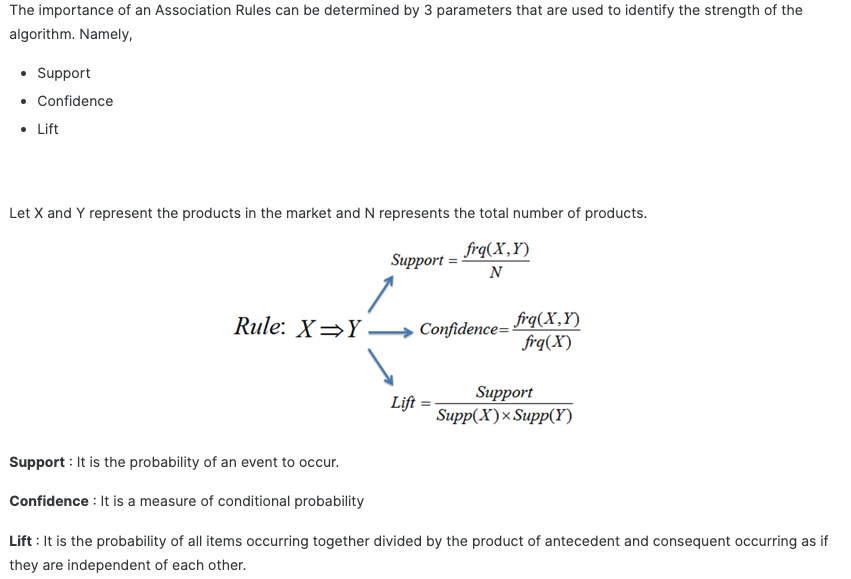
 *Source: https://www.kaggle.com/code/mervetorkan/association-rules-with-python*

So that our result is statistically valid, we need to ensure we will have a minimum support of 5%. This means that at least 5% of the data will have the characteristics that lead to churn. This is defined as `min_support` in the `apriori` function in `mlxtend`.

We also will tweak the minimum threshold value (`min_threshold`) for the confidence level to give us some associative rules, but make sure we're not overwhelming ourselves with information (and being computationally expensive).

*Note: I first carried this out with a confidence level of 60% and got zero results. I then carried it out with 50% and got three results, all with a lift higher than 2x.*

*This was enough to create business recommendatios for the case study, as its best to limit to three to five main points when presenting actionable insights.*

*However, I ran the function again with a confidence level of 30% to get more association rules for context, and in case they could help with any follow up questions.*

#### Executing

First we generate our frequent_itemsets using the apriori function on our one-hot encoded data. We then define our rules, where we constrain association rules with a minimum confidence level. 

Finally in our rules, we freeze the right hand side (or the consequents) to `Calc.IsLapsed_1`, which is our churned customers column. 

We finally display the data, and write it to a csv called 'target_rules.csv'

In [8]:
#Generate frequent itemsets, setting min_support to 0.05 first
frequent_itemsets = apriori(df_onehot, min_support=0.05, use_colnames=True)

#Generate association rules, setting confidence as the metric with a minimum threshold of 0.5
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

#Filter rules to only keep those where consequent contains Calc.IsLapsed=1
target = frozenset(['Calc.IsLapsed_1'])
target_rules = rules[rules['consequents'].apply(lambda x: target.issubset(x))]

# Display the top few rules.
print(target_rules.head())


                                            antecedents        consequents  antecedent support  consequent support  support  confidence      lift  representativity  leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski
9                              (FIRST_YR_CUSTOMER_2012)  (Calc.IsLapsed_1)              0.1400              0.1853   0.0667    0.476429  2.571120               1.0  0.040758    1.556044       0.710540  0.257927   0.357345    0.418193
708         (REVENUE.SCIENTIFIC_REVENUE_2015_binned_Q1)  (Calc.IsLapsed_1)              0.3336              0.1853   0.1244    0.372902  2.012421               1.0  0.062584    1.299158       0.754931  0.315336   0.230271    0.522123
1278                       (USERS.USERS_2015_binned_Q1)  (Calc.IsLapsed_1)              0.5772              0.1853   0.1760    0.304920  1.645549               1.0  0.069045    1.172096       0.927862  0.300085   0.146827    0.627366
1336                  (Calc.TotalRevenue2015_binned_Q1)  (Calc.I

This can take a while (hopefully less than 15 minutes). Once there is a result, we can then write it into a csv.

In [9]:
#print to csv
target_rules.to_csv("target_rules.csv", index=False)

## Results

From our analysis we can see that there are three association rules that have a confidence above 50%. All provide a lift of more than 2.8x. Or in other words **accounts with these characteristics are 2.8x or more likely to lapse.**

</br>

<div class="flourish-embed flourish-table" data-src="visualisation/22173276"><script src="https://public.flourish.studio/resources/embed.js"></script><noscript><img src="https://public.flourish.studio/visualisation/22173276/thumbnail" width="100%" alt="table visualization" /></noscript></div>

</br>

The key takeaway - customers which joined in 2012, with less than 4 users, and have a 0 or missing NPS score are **3.12x** more likely to churn. 

If management was to prevent these accounts churning alone it will lead to an approximate revenue saving of $1.7 million. 

Finally the most common factor was customers joining in 2012. Older accounts are more likely to churn.

### Recommendations

1. Provide more support and attention to customers that joined 3 years or longer
2. Pay attention to needs of customers with 1-4 users – ensure they aren't overpaying. Provide discounts if appropriate
3. Encourage customers to provide NPS scores, with incentives if required
4. Pro-actively engage with customers with low NPS scores

Retaining fifty percent of these customers will represent a saving of USD850,000 to USD1 million.

## Outro

Thanks for reading.

This was a fun piece of predictive analytics to carry out, solving a hypothetical, but realistic business problem. 

A change if I was to do this again, would be to increase the bins in the continuous columns where possible. Perhaps there is a category of customer with a really low value in the columns that was missed out. 

There are other methods to solve this business problem, but this was a fun, and valid exercise to carry out. Carrying it out in Python allowed us to identify three associative rules, and their corresponding lift – as opposed to just one, if we were to do it in Excel. 

Finally, this was the more technical write-up. The more business-oriented write up of this case study can be found here: https://theheasman.com/portfolio/predictive-analytics-science-publisher/

If you have any questions, or want to reach out to discuss a data analysis project (or role), I'm happy to connect on [LinkedIn](https://www.linkedin.com/in/davidheasman/). Include a brief note in your connection request about why you're reaching out.

*David Heasman*
<br>

*London, March 2025*